![](pics/header.jpg)

# Histogram Detection

Kevin J. Walchko, Phd

15 Jan 2017

---


## References

- [OpenCV Python documentation](http://docs.opencv.org/trunk/d6/d00/tutorial_py_root.html)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [3]:
import pylab                                 
pylab.rcParams['figure.figsize'] = (10.0, 18.0)

## Where's Mario?

Let's take a look at trying to find Mario in some images. First we need to convert the image from RGB to HSV color space.
* The **hue** (H) of a color refers to which pure color it resembles. All tints, tones and shades of red have the same hue. Hues are described by a number that specifies the position of the corresponding pure color on the color wheel, as a fraction between 0 and 1. Value 0 refers to red; 1/6 is yellow; 1/3 is green; and so forth around the color wheel.
* The **saturation** (S) of a color describes how white the color is. A pure red is fully saturated, with a saturation of 1; tints of red have saturations less than 1; and white has a saturation of 0.
* The **value** (V) of a color, also called its lightness, describes how dark the color is. A value of 0 is black, with increasing lightness moving away from black

A good resource for understanding RGB and HSV is [colorizer.org](http://colorizer.org/) where you can play with some sliders and see how it changes the color in different color spaces.

For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]. Different softwares use different scales. So if you are comparing OpenCV values with them, you need to normalize these ranges.   [ref](http://docs.opencv.org/trunk/df/d9d/tutorial_py_colorspaces.html)

## Why?

The big reason is that it separates color information (chroma) from intensity or lighting (luma). Because value is separated, you can construct a histogram or thresholding rules using only saturation and hue. This in theory will work regardless of lighting changes in the value channel. In practice it is just a nice improvement. Even by singling out only the hue you still have a very meaningful representation of the base color that will likely work much better than RGB. The end result is a more robust color thresholding over simpler parameters.

Hue is a continuous representation of color so that 0 and 360 are the same hue which gives you more flexibility with the buckets you use in a histogram. Geometrically you can picture the HSV color space as a cone or cylinder with H being the degree, saturation being the radius, and value being the height. 

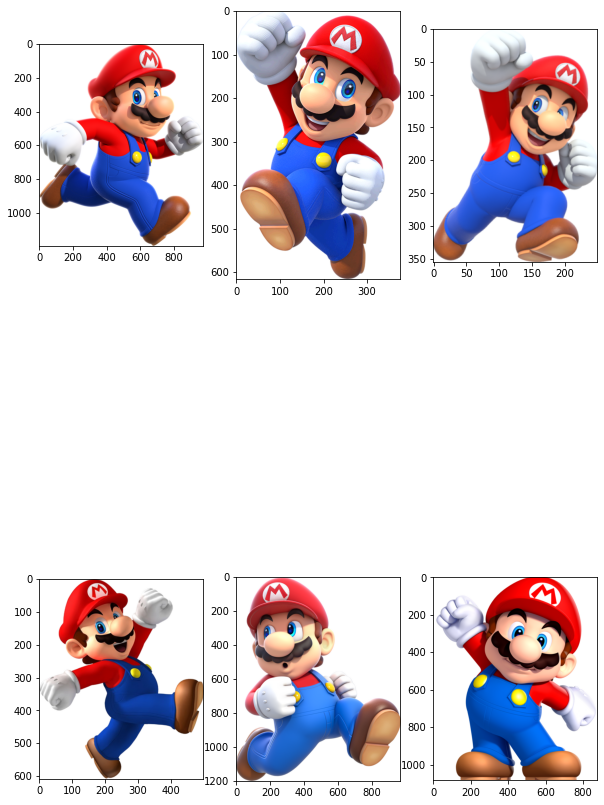

In [5]:
images = ['hist_pics/mario-1.png',
          'hist_pics/mario-2.png',
          'hist_pics/mario-3.png',
          'hist_pics/mario-4.png',
          'hist_pics/mario-5.png',
          'hist_pics/mario-6.png']
rgb = []
for image in images:
    i = cv2.imread(image, cv2.IMREAD_COLOR)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)  # pretty images
    rgb.append(i)

plt.subplot(2,3,1)
plt.imshow(rgb[0]);
plt.subplot(2,3,2)
plt.imshow(rgb[1]);
plt.subplot(2,3,3)
plt.imshow(rgb[2]);
plt.subplot(2,3,4)
plt.imshow(rgb[3]);
plt.subplot(2,3,5)
plt.imshow(rgb[4]);
plt.subplot(2,3,6)
plt.imshow(rgb[5]);

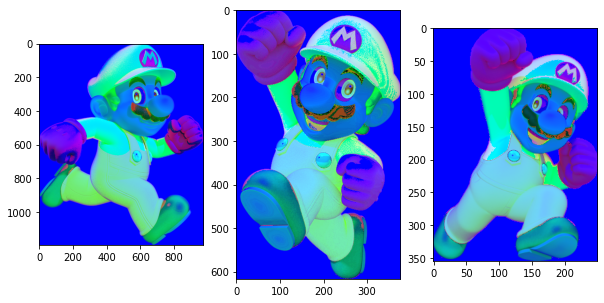

In [6]:
hsv = []
for i, image in enumerate(rgb):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv.append(img)

# we will just plot the first 3, not all 6
plt.subplot(1,3,1)
plt.imshow(hsv[0]);
plt.subplot(1,3,2)
plt.imshow(hsv[1]);
plt.subplot(1,3,3)
plt.imshow(hsv[2]);

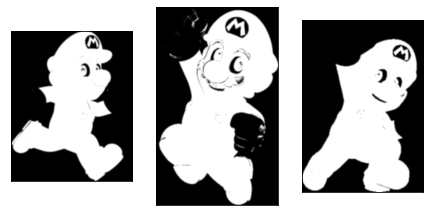

In [8]:
# let's define a mask to block out things we don't want
# since our back ground is white hsv = [x,0,255] where is x is don't care
# white is s=0, v=255
masks = []
for image in hsv:
    h,s,v = cv2.split(image)
#     ret,vv = cv2.threshold(v,250,255,cv2.THRESH_BINARY)
#     masks.append(vv)
    ret,ss = cv2.threshold(s,50,255,cv2.THRESH_BINARY)
    masks.append(ss)
#     ss = cv2.merge((ss,ss,ss))

plt.subplot(1,4,1)
plt.imshow(masks[0], cmap = 'gray', interpolation = 'bicubic');
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(1,4,2)
plt.imshow(masks[1], cmap = 'gray', interpolation = 'bicubic');
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(1,4,3)
plt.imshow(masks[2], cmap = 'gray', interpolation = 'bicubic');
plt.xticks([]), plt.yticks([]);  # to hide tick values on X and Y axis
# plt.colorbar();
# plt.subplot(1,4,4)
# plt.imshow(masks[0]);

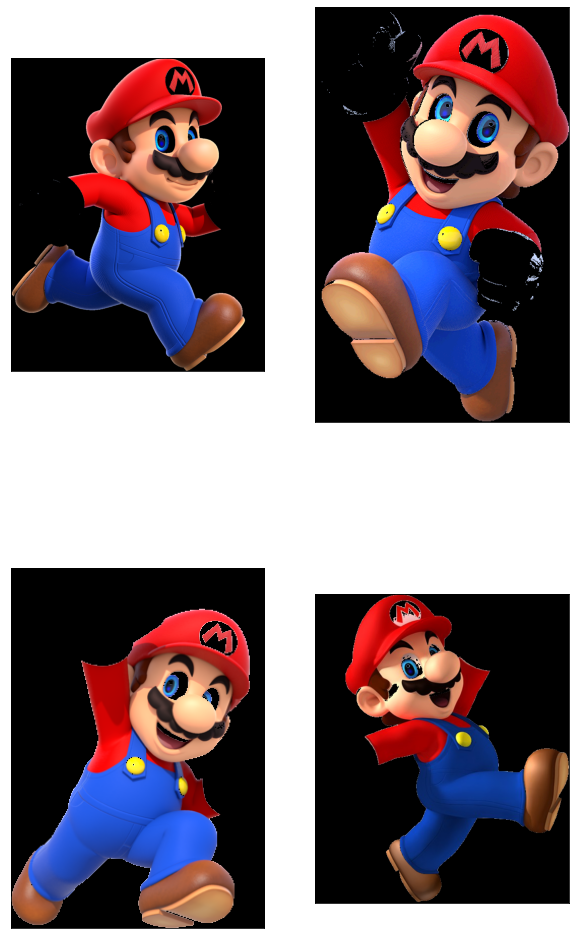

In [9]:
# let's take a look at our masks and see what shows through
tmp = []
for i in range(len(masks)):
    ret = cv2.bitwise_and(rgb[i], cv2.merge((masks[i],masks[i],masks[i])))
    tmp.append(ret)
plt.subplot(2,2,1)
plt.imshow(tmp[0]);
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(2,2,2)
plt.imshow(tmp[1]);
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(2,2,3)
plt.imshow(tmp[2]);
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(2,2,4)
plt.imshow(tmp[3]);
plt.xticks([]), plt.yticks([]);  # to hide tick values on X and Y axis

## Histograms

Let's use OpenCV's histogram function to create them.

    cv2.calcHist(images, channels, mask, histSize, ranges)

1. **images:** This is the image that we want to compute a histogram for. Wrap it as a list: [myImage].
2. **channels:** A list of indices, where we specify the index of the channel we want to compute a histogram for. To compute a histogram of a grayscale image, the list would be [0]. To compute a histogram for all three hue, saturation, and value channels, the channels list would be [0, 1, 2].
3. **mask:** I haven’t covered masking yet, but essentially, a mask is a uint8  image with the same shape as our original image, where pixels with a value of zero are ignored and pixels with a value greater than zero are included in the histogram computation. Using masks allow us to only compute a histogram for a particular region of an image. For now, we’ll just use a value of None for the mask.
4. **histSize:** This is the number of bins we want to use when computing a histogram. Again, this is a list, one for each channel we are computing a histogram for. The bin sizes do not all have to be the same. Here is an example of 32 bins for each channel: [32, 32, 32].
5. **ranges:** The range of possible pixel values. Normally, this is [0, 256] for each channel, but if you are using a color space other than RGB (such as HSV), the ranges might be different.

In [10]:
class hsvHistogram(object):
    """
    This class creates and holds the histogram information of a HSV image. It
    also is used to find our target in a given image. This class is designed
    to construct a 2D histogram looking a t hue and saturation, but not value.
    """
    hist = None
    bins = None
    def __init__(self, bins):
        self.bins = bins
        self.kernel = np.ones((5,5),np.uint8)
        
    def calcHist(self, im_array, masks=None):
        """
        Create a histogram from just images, no arrays
        """
        hist = cv2.calcHist(
            im_array,
            [0, 1],
            masks,
            [self.bins, self.bins],
            [0,180, 0 ,256]
        )
        self.hist = hist
        return hist
        
    def calcHistMask(self, im_array, masks):
        """
        Create a histogram from just images and an array of masks
        """
        hist = self.calcHist([im_array[0]], masks[0])
        for i in range(1, len(im_array)):
            h = self.calcHist([im_array[i]], masks[i])
            hist += h
            
        self.hist = hist
        return hist
    
    def normalize(self):
        cv2.normalize(self.hist,self.hist,0,self.bins,cv2.NORM_MINMAX)
        
    def find(self, test, threshold=3):
        """
        test - target image
        threshold - a tunning parameter
        """
        if self.hist is None:
            print('Need to init histogram first!')
            return 1
        
        dst = cv2.calcBackProject(
            [test],
            [0, 1],
            self.hist,
            [0,180, 0 ,256],
            1
        )
        
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        cv2.filter2D(dst,-1,disc,dst)

        # cv2.threshold(image, low, high, method)
        ret, thresh = cv2.threshold(dst,threshold,255,cv2.THRESH_BINARY)

        # morphological/blobify --------
        # thresh = cv2.erode(thresh, self.kernel)
        # thresh = cv2.dilate(thresh, self.kernel)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, self.kernel)
        return thresh
    
    def plot(self):
#         plt.plot(np.linspace(0,180,roiHist.bins), roiHist.hist)
#         plt.grid(True)
#         plt.xlabel('Hue')
        plt.imshow(self.hist,interpolation = 'nearest')
        plt.ylabel('Hue [0-179]')
        plt.xlabel('Saturation [0-255]')
        plt.title('Histogram')
        plt.colorbar()

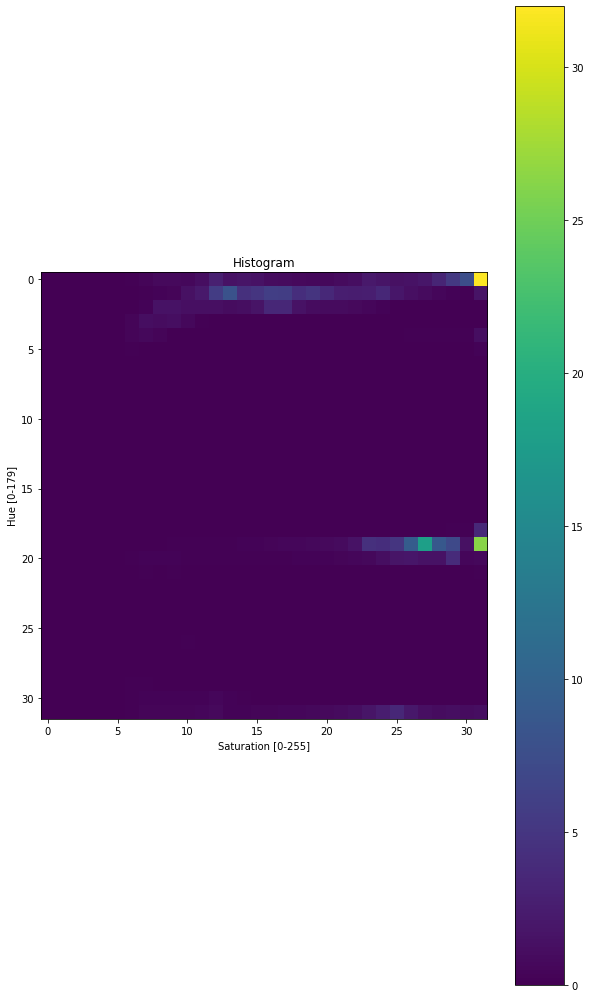

In [11]:
roiHist = hsvHistogram(32)
# roiHist.calcHist([hsv[1]], masks[1])
roiHist.calcHistMask(hsv, masks)
roiHist.normalize()
roiHist.plot()

# Test

Can we find the target image in another picture? The results aren't perfect, but we definately find our target. Now to be fair, these are synthetic images and the artists used the same colors for multiple characters, so I am impressed it worked at all.

(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

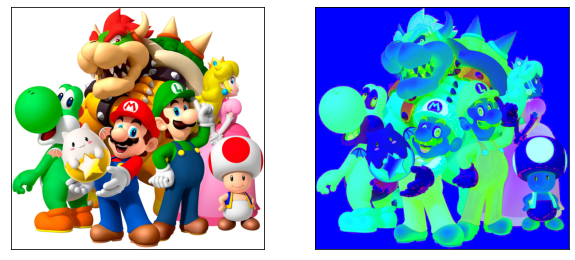

In [12]:
test_rgb = cv2.imread('hist_pics/mario-test2.jpg')
# test_rgb = rgb[0]
test_rgb = cv2.cvtColor(test_rgb, cv2.COLOR_BGR2RGB)  # make pretty for ipython
test_hsv = cv2.cvtColor(test_rgb, cv2.COLOR_RGB2HSV)  # now convert to HSV

plt.subplot(1,2,1)
plt.imshow(test_rgb);
plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(test_hsv);
plt.xticks([]), plt.yticks([])

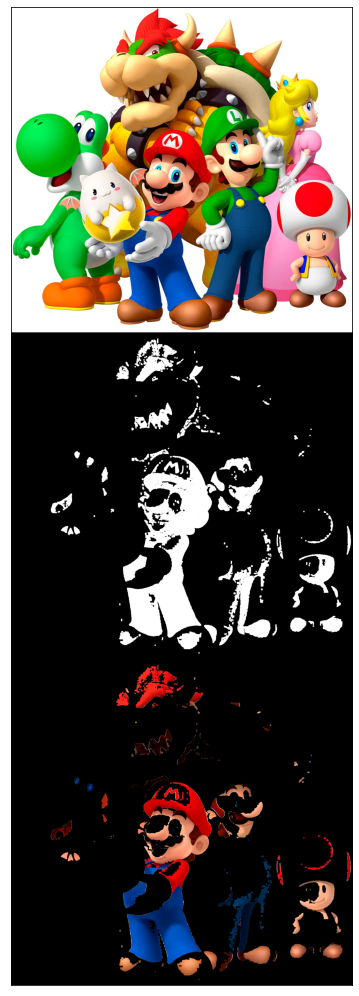

In [13]:
thresh = roiHist.find(test_hsv, 50)
thresh = cv2.merge((thresh,thresh,thresh))  # make 3 channels

# plot ----------
res = cv2.bitwise_and(test_rgb,thresh)
pics = np.vstack((test_rgb,thresh,res))
plt.imshow(pics);
plt.xticks([]), plt.yticks([]);

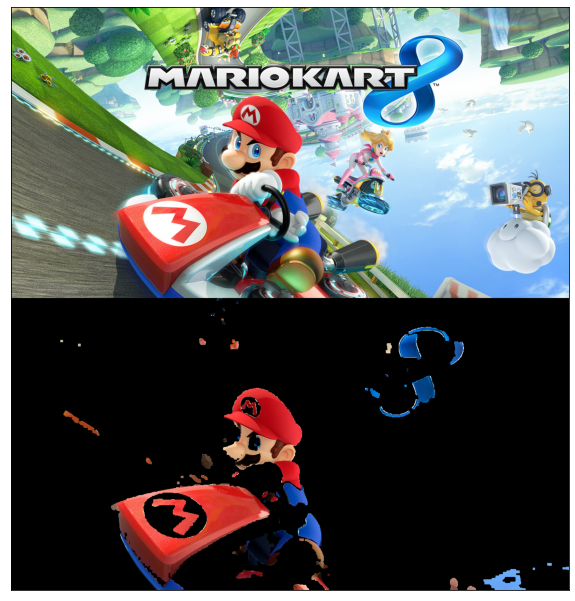

In [14]:
test_rgb = cv2.imread('hist_pics/mario-test4.jpg')
test_rgb = cv2.cvtColor(test_rgb, cv2.COLOR_BGR2RGB)  # make pretty for ipython
test_hsv = cv2.cvtColor(test_rgb, cv2.COLOR_RGB2HSV)  # now convert to HSV
thresh = roiHist.find(test_hsv, 15)
thresh = cv2.merge((thresh,thresh,thresh))  # make 3 channels
res = cv2.bitwise_and(test_rgb,thresh)
pics = np.vstack((test_rgb,res))
plt.imshow(pics);
plt.xticks([]), plt.yticks([]);

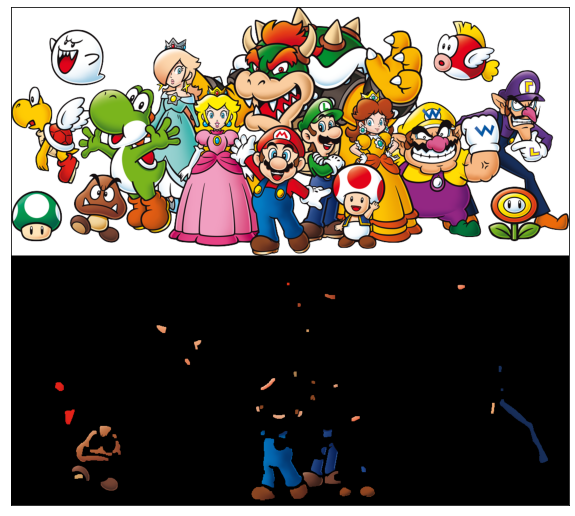

In [15]:
test_rgb = cv2.imread('hist_pics/mario-test.png')
test_rgb = cv2.cvtColor(test_rgb, cv2.COLOR_BGR2RGB)  # make pretty for ipython
test_hsv = cv2.cvtColor(test_rgb, cv2.COLOR_RGB2HSV)  # now convert to HSV
thresh = roiHist.find(test_hsv, 50)
thresh = cv2.merge((thresh,thresh,thresh))  # make 3 channels
res = cv2.bitwise_and(test_rgb,thresh)
pics = np.vstack((test_rgb,res))
plt.imshow(pics);
plt.xticks([]), plt.yticks([]);

# plt.subplot(2,1,1)
# plt.imshow(test_rgb);
# plt.xticks([]), plt.yticks([]);

# plt.subplot(2,1,2)
# plt.imshow(res);
# plt.xticks([]), plt.yticks([]);

Histogram matching alows us to detect much more complex things, but it isn't perfect. How could you maybe improve this?

- We are only looking at color information, but spacial information (relative distances between color groups) would help avoid detections all over the image.
- In real life you could also look at texture of your target (frequency information caused by natural material) to help differentiate Mario's red cloth hat from his red metal car.
- You could add in machine learning and begin to classify things like: Mario pants

Depending on your application and how much processing time you have, there could be other things you could add to this.